Librerías importadas correctamente.

Generando un conjunto de datos simulado...

Primeras 5 filas del dataset:
   ingresos_mensuales  deuda_actual  historial_crediticio nivel_educativo  \
0                7770         12725                     1        superior   
1                1360         10357                     0          básico   
2                5890           770                     0           medio   
3                5726         12154                     1          básico   
4                5691          4363                     0          básico   

   años_experiencia  edad  aprobado_credito  
0                 7    53                 1  
1                18    36                 0  
2                 0    18                 0  
3                28    27                 1  
4                34    53                 1  

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column

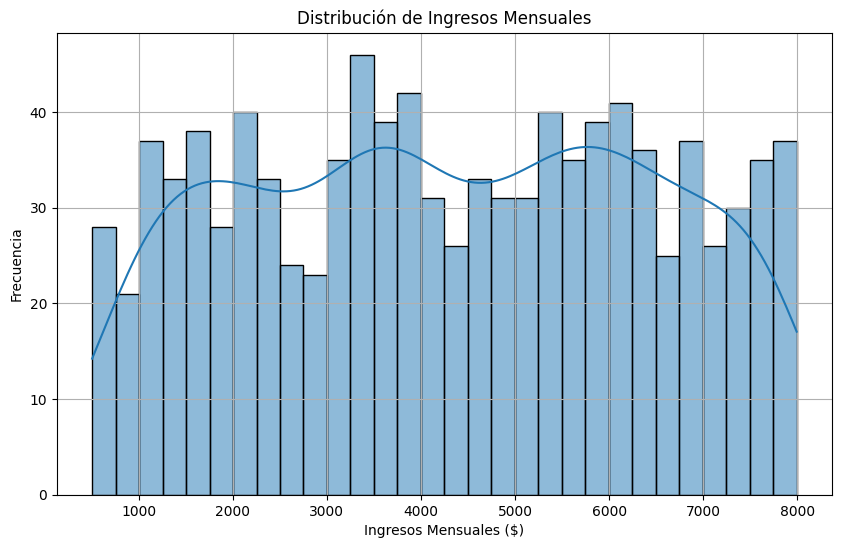

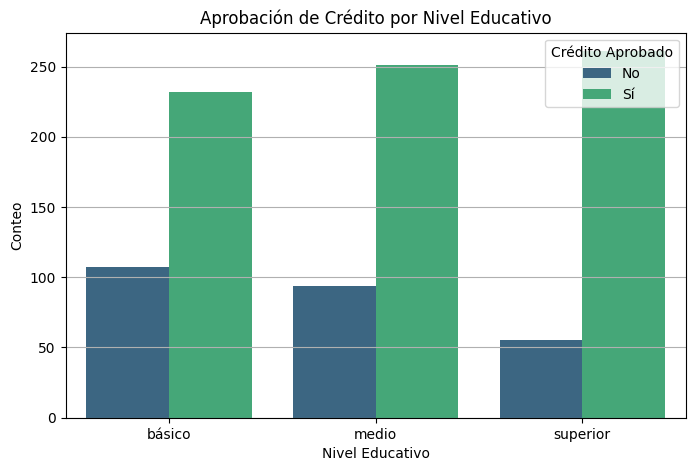


Codificando variables categóricas...
Mapeo del nivel educativo: {'básico': 0, 'medio': 1, 'superior': 2}

Dataset con columna codificada:
  nivel_educativo  nivel_educativo_encoded
0        superior                        2
1          básico                        0
2           medio                        1
3          básico                        0
4          básico                        0

Dividiendo los datos en conjuntos de entrenamiento y prueba...
Tamaño del set de entrenamiento: 800 registros
Tamaño del set de prueba: 200 registros

--- Entrenando y Evaluando Modelos ---
Accuracy (Regresión Logística): 0.9050
Accuracy (Árbol de Decisión):  0.8300

Matriz de Confusión (Árbol de Decisión):


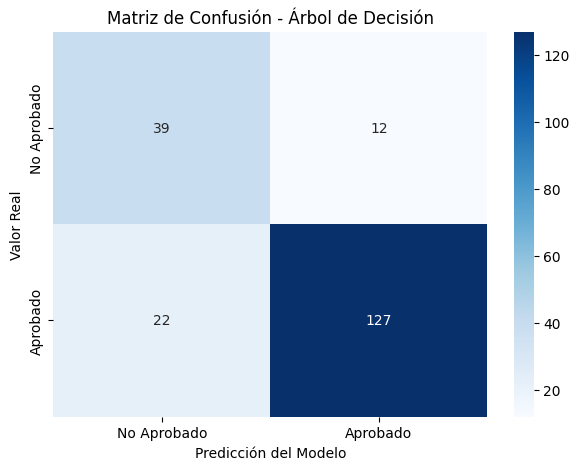


Se ha seleccionado el Árbol de Decisión como el modelo final.

Preparando la interfaz de usuario con Gradio...

--- Lanzando Interfaz de Gradio ---
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3ce178dce8c378c537.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3ce178dce8c378c537.gradio.live


In [3]:
# ==============================================================================
# PROYECTO: MODELO DE PREDICCIÓN DE MICROCRÉDITOS - ANDERSON MENDOZA
# ==============================================================================
# Este notebook contiene todos los pasos para crear, entrenar y desplegar
# un modelo que predice la aprobación de microcréditos.
# ==============================================================================


# ==============================================================================
# PASO 0: INSTALACIÓN DE LIBRERÍAS
# ==============================================================================
# Se asegura de que la librería Gradio esté instalada para la interfaz web.
try:
    import gradio as gr
except ImportError:
    print("Instalando Gradio...")
    !pip install -q gradio
    import gradio as gr


# ==============================================================================
# PASO 1: PREPARACIÓN
# ==============================================================================

# ------------------------------------------------------------------------------
# Importación de librerías necesarias
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Librerías importadas correctamente.")

# ------------------------------------------------------------------------------
# Cargar Dataset (Simulado para este ejemplo)
# ------------------------------------------------------------------------------
print("\nGenerando un conjunto de datos simulado...")
np.random.seed(42) # Para reproducibilidad
num_registros = 1000

datos = {
    'ingresos_mensuales': np.random.randint(500, 8000, size=num_registros), # Rango de ingresos en USD
    'deuda_actual': np.random.randint(0, 15000, size=num_registros), # Rango de deuda en USD
    'historial_crediticio': np.random.randint(0, 2, size=num_registros), # 0: malo, 1: bueno
    'nivel_educativo': np.random.choice(['básico', 'medio', 'superior'], size=num_registros),
    'años_experiencia': np.random.randint(0, 40, size=num_registros),
    'edad': np.random.randint(18, 70, size=num_registros)
}

df = pd.DataFrame(datos)

# Simular la variable objetivo 'aprobado_credito' con cierta lógica
probabilidad = (df['ingresos_mensuales'] / 8000 +
                df['historial_crediticio'] * 0.5 +
                df['años_experiencia'] / 40 +
                (df['nivel_educativo'] == 'superior') * 0.2 -
                df['deuda_actual'] / 30000)

df['aprobado_credito'] = (probabilidad + np.random.normal(0, 0.2, num_registros) > 0.75).astype(int)

print("\nPrimeras 5 filas del dataset:")
print(df.head())
print("\nInformación general del dataset:")
df.info()

# ------------------------------------------------------------------------------
# Visualizar y entender variables
# ------------------------------------------------------------------------------
print("\n--- Visualización de Datos ---")

# Histograma de ingresos mensuales
plt.figure(figsize=(10, 6))
sns.histplot(df['ingresos_mensuales'], bins=30, kde=True)
plt.title('Distribución de Ingresos Mensuales')
plt.xlabel('Ingresos Mensuales ($)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Gráfico de barras para el nivel educativo
plt.figure(figsize=(8, 5))
sns.countplot(x='nivel_educativo', data=df, hue='aprobado_credito', order=['básico', 'medio', 'superior'], palette='viridis')
plt.title('Aprobación de Crédito por Nivel Educativo')
plt.xlabel('Nivel Educativo')
plt.ylabel('Conteo')
plt.legend(title='Crédito Aprobado', labels=['No', 'Sí'])
plt.grid(axis='y')
plt.show()

# ------------------------------------------------------------------------------
# Limpiar datos y codificar texto a números
# ------------------------------------------------------------------------------
print("\nCodificando variables categóricas...")
label_encoder = LabelEncoder()
df['nivel_educativo_encoded'] = label_encoder.fit_transform(df['nivel_educativo'])
mapeo_educativo = {label: index for index, label in enumerate(label_encoder.classes_)}
mapeo_clases_educativo = label_encoder.classes_
print(f"Mapeo del nivel educativo: {mapeo_educativo}")

print("\nDataset con columna codificada:")
print(df[['nivel_educativo', 'nivel_educativo_encoded']].head())


# ==============================================================================
# PASO 2: MODELADO
# ==============================================================================

# ------------------------------------------------------------------------------
# Separar datos: entrenamiento/test
# ------------------------------------------------------------------------------
print("\nDividiendo los datos en conjuntos de entrenamiento y prueba...")
features = ['ingresos_mensuales', 'deuda_actual', 'historial_crediticio', 'años_experiencia', 'edad', 'nivel_educativo_encoded']
target = 'aprobado_credito'
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Tamaño del set de entrenamiento: {X_train.shape[0]} registros")
print(f"Tamaño del set de prueba: {X_test.shape[0]} registros")

# ------------------------------------------------------------------------------
# Entrenar y evaluar modelos
# ------------------------------------------------------------------------------
print("\n--- Entrenando y Evaluando Modelos ---")
# Modelo 1: Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Accuracy (Regresión Logística): {acc_log_reg:.4f}")

# Modelo 2: Árbol de Decisión
dec_tree = DecisionTreeClassifier(random_state=42, max_depth=5)
dec_tree.fit(X_train, y_train)
y_pred_dec_tree = dec_tree.predict(X_test)
acc_dec_tree = accuracy_score(y_test, y_pred_dec_tree)
print(f"Accuracy (Árbol de Decisión):  {acc_dec_tree:.4f}")

# Matriz de Confusión para el Árbol de Decisión
print("\nMatriz de Confusión (Árbol de Decisión):")
cm = confusion_matrix(y_test, y_pred_dec_tree)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Aprobado', 'Aprobado'], yticklabels=['No Aprobado', 'Aprobado'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()

# Se elige el Árbol de Decisión como modelo final por su rendimiento y interpretabilidad
modelo_final = dec_tree
print("\nSe ha seleccionado el Árbol de Decisión como el modelo final.")


# ==============================================================================
# PASO 3: INTERACCIÓN Y DESPLIEGUE
# ==============================================================================

# ------------------------------------------------------------------------------
# Crear función de predicción por input
# ------------------------------------------------------------------------------
def predecir_aprobacion(ingresos, deuda, historial, experiencia, edad, educacion):
    """
    Función que recibe los datos de un solicitante y predice la aprobación del crédito.
    """
    try:
        educacion_encoded = mapeo_educativo[educacion]
        input_data = pd.DataFrame({
            'ingresos_mensuales': [ingresos],
            'deuda_actual': [deuda],
            'historial_crediticio': [1 if historial == 'Bueno' else 0],
            'años_experiencia': [experiencia],
            'edad': [edad],
            'nivel_educativo_encoded': [educacion_encoded]
        })
        prediccion = modelo_final.predict(input_data)[0]
        probabilidad_pred = modelo_final.predict_proba(input_data)[0]

        if prediccion == 1:
            resultado = "✅ APROBADO"
            confianza = f"Confianza: {probabilidad_pred[1]:.2%}"
        else:
            resultado = "❌ NO APROBADO"
            confianza = f"Confianza: {probabilidad_pred[0]:.2%}"
        return resultado, confianza
    except Exception as e:
        return f"Error: {e}", ""

# ------------------------------------------------------------------------------
# (Opcional) Construir interfaz con Gradio
# ------------------------------------------------------------------------------
print("\nPreparando la interfaz de usuario con Gradio...")

# ===== LÍNEA CORREGIDA =====
# Se cambió secondary_hue de "light_blue" a "sky", que es un color válido.
with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue", secondary_hue="sky"), title="Predicción de Crédito") as demo:
    gr.Markdown(
        """
        # 🤖 **Modelo de Predicción de Aprobación de Microcréditos**
        Introduce los datos del solicitante para obtener una predicción instantánea sobre la viabilidad del crédito.
        """
    )
    with gr.Row():
        with gr.Column(scale=2):
            gr.Markdown("### 💼 Información Financiera y Laboral")
            ingresos_mensuales = gr.Number(label="Ingresos Mensuales ($)", value=3000)
            deuda_actual = gr.Number(label="Deuda Actual Total ($)", value=2500)
            años_experiencia = gr.Slider(label="Años de Experiencia Laboral", minimum=0, maximum=50, step=1, value=10)
        with gr.Column(scale=2):
            gr.Markdown("### 👤 Información Personal")
            historial_crediticio = gr.Radio(label="Historial Crediticio Previo", choices=['Bueno', 'Malo'], value='Bueno')
            nivel_educativo = gr.Dropdown(label="Nivel Educativo Máximo", choices=list(mapeo_clases_educativo), value='medio')
            edad = gr.Slider(label="Edad", minimum=18, maximum=80, step=1, value=35)

    btn_predecir = gr.Button("Analizar Solicitud y Predecir", variant="primary")
    with gr.Row():
        resultado_prediccion = gr.Label(label="Resultado de la Predicción", scale=3)
        confianza_prediccion = gr.Label(label="Confianza", scale=2)

    btn_predecir.click(
        fn=predecir_aprobacion,
        inputs=[ingresos_mensuales, deuda_actual, historial_crediticio, años_experiencia, edad, nivel_educativo],
        outputs=[resultado_prediccion, confianza_prediccion]
    )
    gr.Markdown(
        """
        ---
        *Este es un modelo de demostración. Las predicciones se basan en datos simulados y no deben considerarse como asesoramiento financiero.*
        """
    )

print("\n--- Lanzando Interfaz de Gradio ---")
demo.launch(debug=True)